In [1]:
import pandas as pd
from tqdm import tqdm 
from downcast import reduce
import numpy as np

from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.naive import NaiveForecaster
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")


In [2]:
sales_validation = pd.read_csv(r'dataset/sales_train_validation.csv')
sales_evaluation = pd.read_csv(r'dataset/sales_train_evaluation.csv')
calendar = pd.read_csv(r'dataset/calendar.csv')
prices = pd.read_csv(r'dataset/sell_prices.csv')
calendar = calendar.fillna('RegularDay')
sales_validation.id = sales_validation.id.str.replace('_validation', '')
sales_evaluation.id = sales_evaluation.id.str.replace('_evaluation', '')

In [4]:
def featurize_train_data(sales_data, calendar, prices):
    melted_sales_validation = pd.melt(sales_data, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='d', value_name='sales')
    df = pd.merge(melted_sales_validation, calendar, on='d', how='left')
    df = pd.merge(df, prices, on=['store_id','item_id','wm_yr_wk'], how='left') 
    for i in tqdm(list(range(1, 7))):
        df['lag_'+str(i)] = df.groupby(['id'])['sales'].shift(i)
        df['diff1_'+str(i)] = df.groupby(['id'])['sales'].shift(i).diff(1)
        df['diff7_'+str(i)] = df.groupby(['id'])['sales'].shift(i).diff(7)
    for i in tqdm(list(range(7,85,7))):
        df['lag_'+str(i)] = df.groupby(['id'])['sales'].shift(i) 
        df['diff1_'+str(i)] = df.groupby(['id'])['sales'].shift(i).diff(1)
        df['diff7_'+str(i)] = df.groupby(['id'])['sales'].shift(i).diff(7)
    for i in tqdm(list(range(7,85,7))):
        df['rolling_mean_'+str(i)] = df.groupby(['id'])['sales'].shift(i).rolling(i).mean()
        df['rolling_median_'+str(i)] = df.groupby(['id'])['sales'].shift(i).rolling(i).median()
        df['rolling_std_'+str(i)] = df.groupby(['id'])['sales'].shift(i).rolling(i).std()
        df['rolling_max_'+str(i)] = df.groupby(['id'])['sales'].shift(i).rolling(i).max()
        df['rolling_skew_'+str(i)] = df.groupby(['id'])['sales'].shift(i).rolling(i).skew() 
        df['rolling_kurt_'+str(i)] = df.groupby(['id'])['sales'].shift(i).rolling(i).kurt()
    for i in tqdm(list(range(8,85,7))):
        df['rolling_mean_'+str(i)] = df.groupby(['id'])['sales'].shift(i).rolling(i).mean()
        df['rolling_std_'+str(i)] = df.groupby(['id'])['sales'].shift(i).rolling(i).std()
        df['rolling_median_'+str(i)] = df.groupby(['id'])['sales'].shift(i).rolling(i).median()
    #df = reduce(df)
    df = df.fillna(0)
    cols = ['event_name_1','event_type_1','event_name_2','event_type_2','id','item_id','dept_id','cat_id','store_id','state_id']
    label_encoders = {}
    for i in tqdm(cols):
        labelencoder=LabelEncoder()
        df[i+'_encoded'] = labelencoder.fit_transform(df[i].astype(str))
        label_encoders[i] = labelencoder
    df.d = df.d.apply(lambda x: x.split('_')[1]).astype(int)

    df = reduce(df)
    
    x = df.drop(['id','item_id','dept_id','cat_id','store_id','state_id','weekday','date','month','year','event_name_1','event_type_1','event_name_2','event_type_2'], axis=1)
    y = df[['d','sales']]
    x_train=x.loc[(x['d']>=1115)&(x['d']<=1885)].copy()
    x_cv=x.loc[(x['d']>1885)].copy()

    y_train=y.loc[(x['d']>=1115)&(y['d']<=1885)].copy()
    y_cv=y.loc[(y['d']>1885)].copy()

    x_train.drop(['d', 'sales'], axis=1, inplace=True)
    x_cv.drop(['d', 'sales'], axis=1, inplace=True)

    y_train.drop(['d'], axis=1, inplace=True)
    y_cv.drop(['d'], axis=1, inplace=True)

    scaler = StandardScaler()
    x_train_std = scaler.fit_transform(x_train)
    x_cv_std = scaler.transform(x_cv)

    return x_train.columns, scaler, label_encoders, x_train_std, x_cv_std, y_train, y_cv

def featurize_test_data(sales_data, calendar, prices, scaler, label_encoders):
    melted_sales_validation = pd.melt(sales_data, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='d', value_name='sales')
    df = pd.merge(melted_sales_validation, calendar, on='d', how='left')
    df = pd.merge(df, prices, on=['store_id','item_id','wm_yr_wk'], how='left') 
    for i in tqdm(list(range(1, 7))):
        df['lag_'+str(i)] = df.groupby(['id'])['sales'].shift(i)
        df['diff1_'+str(i)] = df.groupby(['id'])['sales'].shift(i).diff(1)
        df['diff7_'+str(i)] = df.groupby(['id'])['sales'].shift(i).diff(7)
    for i in tqdm(list(range(7,85,7))):
        df['lag_'+str(i)] = df.groupby(['id'])['sales'].shift(i) 
        df['diff1_'+str(i)] = df.groupby(['id'])['sales'].shift(i).diff(1)
        df['diff7_'+str(i)] = df.groupby(['id'])['sales'].shift(i).diff(7)
    for i in tqdm(list(range(7,85,7))):
        df['rolling_mean_'+str(i)] = df.groupby(['id'])['sales'].shift(i).rolling(i).mean()
        df['rolling_median_'+str(i)] = df.groupby(['id'])['sales'].shift(i).rolling(i).median()
        df['rolling_std_'+str(i)] = df.groupby(['id'])['sales'].shift(i).rolling(i).std()
        df['rolling_max_'+str(i)] = df.groupby(['id'])['sales'].shift(i).rolling(i).max()
        df['rolling_skew_'+str(i)] = df.groupby(['id'])['sales'].shift(i).rolling(i).skew() 
        df['rolling_kurt_'+str(i)] = df.groupby(['id'])['sales'].shift(i).rolling(i).kurt()
    for i in tqdm(list(range(8,85,7))):
        df['rolling_mean_'+str(i)] = df.groupby(['id'])['sales'].shift(i).rolling(i).mean()
        df['rolling_std_'+str(i)] = df.groupby(['id'])['sales'].shift(i).rolling(i).std()
        df['rolling_median_'+str(i)] = df.groupby(['id'])['sales'].shift(i).rolling(i).median()

    #df = reduce(df) 
    df = df.fillna(0)
    cols = ['event_name_1','event_type_1','event_name_2','event_type_2','id','item_id','dept_id','cat_id','store_id','state_id']
    for i in tqdm(cols):
        df[i+'_encoded'] = label_encoders[i].transform(df[i].astype(str))
    df.d = df.d.apply(lambda x: x.split('_')[1]).astype(int)

    df = reduce(df)
    
    x = df.drop(['id','item_id','dept_id','cat_id','store_id','state_id','weekday','date','month','year','event_name_1','event_type_1','event_name_2','event_type_2'], axis=1)
    y = df[['d','sales']]
    x_test = x.loc[(x['d']>=1914)].copy()

    y_test = y.loc[(x['d']>=1914)].copy()

    x_test.drop(['d', 'sales'], axis=1, inplace=True)

    y_test.drop(['d'], axis=1, inplace=True)

    x_test_std = scaler.transform(x_test)

    return x_test.columns, x_test_std, y_test



In [5]:
train_features, scaler, label_encoders, x_train_std, x_cv_std, y_train, y_cv = featurize_train_data(sales_validation, calendar, prices)

100%|██████████| 10/10 [00:21<00:00,  2.11s/it]


In [ ]:
test_features, x_test_std, y_test = featurize_test_data(sales_evaluation, calendar, prices, scaler, label_encoders)

In [12]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor(max_depth=11, min_samples_split=3, min_samples_leaf=5, random_state=0)
model.fit(x_train_std, y_train)

DecisionTreeRegressor(max_depth=11, min_samples_leaf=5, min_samples_split=3,
                      random_state=0)

<AxesSubplot: ylabel='feature'>

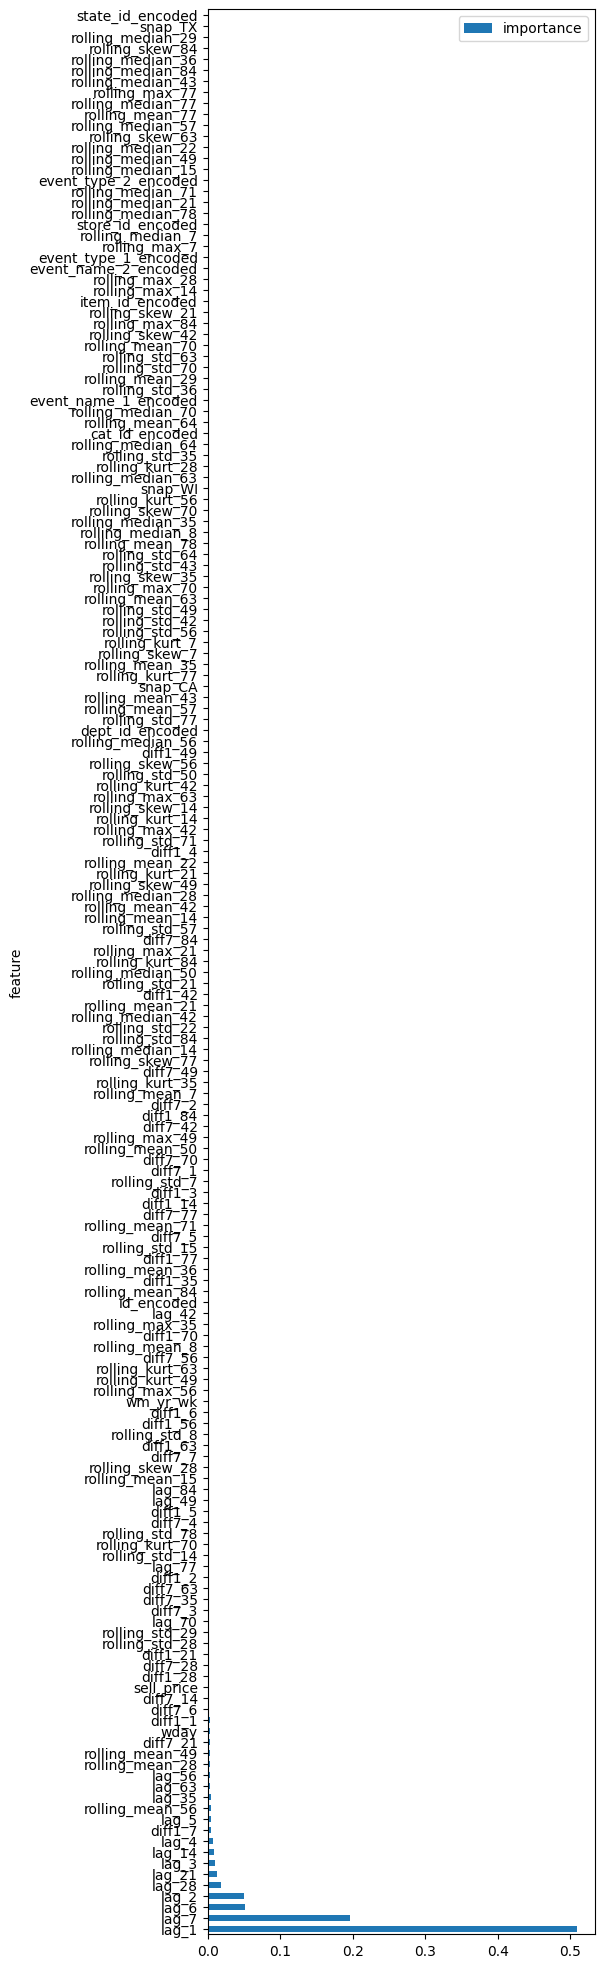

In [13]:
feature_importance = pd.DataFrame({'feature':train_features, 'importance':model.feature_importances_}).sort_values('importance', ascending=False)
feature_importance.plot(kind='barh', x='feature', y='importance', figsize=(5,25))

In [16]:
feature_importance.sort_values('importance', ascending=False).head(20)

,feature,importance
6,lag_1,0.508546
24,lag_7,0.196271
21,lag_6,0.051359
9,lag_2,0.050060
33,lag_28,0.018872
30,lag_21,0.013458
12,lag_3,0.010191
27,lag_14,0.008389
15,lag_4,0.006900
25,diff1_7,0.004650


In [15]:
print('Train RMSE:', np.sqrt(mean_squared_error(y_train, model.predict(x_train_std))))
print('CV RMSE:', np.sqrt(mean_squared_error(y_cv, model.predict(x_cv_std))))
print('Test RMSE:', np.sqrt(mean_squared_error(y_test, model.predict(x_test_std))))

Train RMSE: 2.013291203002958
CV RMSE: 2.0464396329462837
Test RMSE: 2.1817748288993863
